# Baseline Greyscale Image Classifier Model To Get Started with PyTorch

## 1. Introduction

PyTorch is a brilliant framework for crafting neural networks, especially when you’re tackling unstructured data like images. But if you’re not wrestling with PyTorch or image classification daily, getting started can feel a little sluggish. Why? PyTorch asks for some boilerplate code to set the stage. Once that’s sorted, though, the playground opens up — you’re free to experiment and dig into the good stuff.

In this notebook, I’ll guide you through a quick, no-fuss approach to building a greyscale multi-class image classifier — a classic in beginner tutorials and machine learning competitions. We’ll create a solid baseline model that skips the cutting-edge frills but delivers what you’d expect from a decent classifier. That said, I’ll toss in a couple of fresher tricks like training-time validation augmentation and a brute-force accuracy boost via Test-Time Augmentation (TTA) without diving into ensemble madness. These can be gold when you’re stuck with a small dataset and chasing leaderboard glory (top spot, anyone?).

Instead of designing a model from the ground up, we’ll borrow the smallest EfficientNet — a lean, mean Artificial Neural Network (ANN). Reusing established architectures is practically the golden rule now, especially for standard tasks like this. We won’t grab a pretrained version, but we’ll adapt its structure: swapping the first convolution block to handle greyscale images (not RGB) and tweaking the decision head to match our number of classes. From there, it’s standard training — with a clever twist for validation.

Normally, you’d use a validation set during training to check how your model fares on unseen data. But with a tiny validation pool, luck can sneak in —maybe your model aces it because the weights just clicked, or the samples were accidentally simple. I’m a bit paranoid about that (in a good way!), so we’ll shake things up.

When data’s scarce — or even when it’s abundant — training-time augmentation is a go-to move to churn out endless variations and keep overfitting at bay. We’ll apply this to training *and* validation. Yep, instead of a fixed validation set, we’ll generate unlimited augmented versions. No model can bluff its way to high accuracy when the target keeps morphing — it has to truly grasp the images’ core to survive. It’s a slightly quirky method, but it’s like a bootcamp for your model. The hope? If it shines through this chaos, it’ll breeze through plain validation images too.

We’ll stretch this idea to inference with Test-Time Augmentation. Rather than predicting one raw image, we’ll augment it into multiple versions, predict each, and let the model vote on the final call. It’s a neat way to nudge up performance — like a group huddle before the answer. Plus, in a real-world setup (especially a rough one), it might just trip up any sneaky adversaries. That’s a story for another day, though!

Enough talk—let’s dive in and get our hands dirty!

## 2. Code Essentials for Our Classifier

Here’s where we assemble the bits and pieces for our greyscale classifier. Below, you’ll find everything laid out: library imports, a couple of functions, and the classes that’ll carry the load. It’s all rather sensible, so no need to steel yourself for a struggle.

We begin with the library imports—the familiar tools we’ll depend on. Then, we define two functions for later. `load_fashion_mnist` fetches our toy dataset: greyscale 28x28 images of clothes and shoes, divided into 10 classes. It’s much like the classic MNIST, only with a touch more sartorial flair. Next, `apply_augmentations` deals with image adjustments for visualisation—nothing extravagant, just enough to get a clear view.

For augmentations, we’ve included `SaltAndPepperNoise` and `GaussianNoise` as custom touches, alongside PyTorch’s built-in options. They bring a hint of grit to test the model’s mettle. `ImageDataset` ties into PyTorch’s DataLoader to deliver the images, applying augmentations on the spot—neat and practical.

The core of it all is `EfficientNetClassifier`, which provides a clean `fit-predict` framework for training and inference. Its `fit` method comes with some handy features: validation against your data, early stopping (if no improvement shows after *patience* epochs, it halts), and a rollback to the best model if training stops. You can also opt to augment the validation set during training. This makes it a tougher test, offering a more guarded performance estimate—less rosy, more grounded, so the model proves itself on the plain data that actually counts.

The `predict` method keeps things simple but adds a twist with TTA. You can stick with the same augmentations used during training or swap in a new set, perhaps better matched to what you’d expect from out-of-sample data. Give it a go to see if it nudges the results up a bit—could be worth the effort.

Right then, let’s move to the code and get this classifier underway.

In [1]:
import logging
import warnings

import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import mode
from sklearn.model_selection import train_test_split
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.metrics import accuracy_score, f1_score
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset
from torchvision import models, transforms, datasets
from tqdm import tqdm

warnings.filterwarnings("ignore")
logging.basicConfig(level=logging.INFO, format="%(asctime)s - %(levelname)s - %(message)s")

plt.rcParams['figure.figsize'] = (12, 6)
plt.rcParams['figure.constrained_layout.use'] = True

def load_fashion_mnist():
    """Downloads Fashion MNIST and returns images (X) and labels (Y) as NumPy arrays."""
    train = datasets.FashionMNIST(root="./data", train=True, download=True)
    test = datasets.FashionMNIST(root="./data", train=False, download=True)

    X = np.concatenate([(train.data / 255.0).reshape(len(train), -1),
                        (test.data / 255.0).reshape(len(test), -1)])
    Y = np.concatenate([train.targets, test.targets])

    return X.astype(np.float32), Y.astype(np.int64), train.classes

def apply_augmentation(image, augmentation_transforms, num_samples=5):
    """
    Apply augmentations to a single square image and return multiple augmented versions.

    Args:
        image (np.ndarray or torch.Tensor): Input image (flattened or HxW)
        augmentation_transforms (callable): Transform to apply
        num_samples (int): Number of augmented versions (default: 5)

    Returns:
        list: Augmented images as NumPy arrays

    Raises:
        ValueError: If image shape or num_samples is invalid
    """
    if num_samples <= 0:
        raise ValueError(f"num_samples must be positive, got {num_samples}")

    # Convert NumPy to tensor
    if isinstance(image, np.ndarray):
        if image.dtype == np.uint8:
            image = image.astype(np.float32) / 255.0
        elif image.dtype not in (np.float32, np.float64):
            raise ValueError(f"Unsupported dtype: {image.dtype}")
        else:
            image = image.astype(np.float32)

        # Handle shape: flattened or 2D square
        if image.ndim == 1:
            n = int(image.shape[0] ** 0.5)
            if n * n != image.shape[0]:
                raise ValueError(f"Flattened size {image.shape[0]} must be a perfect square")
            image = image.reshape(n, n)
        elif image.ndim == 2 and image.shape[0] != image.shape[1]:
            raise ValueError(f"Image must be square, got {image.shape}")
        elif image.ndim > 2:
            raise ValueError(f"Expected 1D or 2D input, got {image.shape}")

        image = torch.tensor(image, dtype=torch.float32).unsqueeze(0)

    # Validate tensor shape (1, H, H)
    if image.dim() != 3 or image.shape[1] != image.shape[2]:
        raise ValueError(f"Tensor must be 1xHxH (square grayscale), got {image.shape}")

    # Generate augmented versions
    augmented_images = [
        augmentation_transforms(image.clone()).squeeze(0).cpu().numpy()
        for _ in range(num_samples)
    ]

    return augmented_images

class SaltAndPepperNoise:
    """
    Apply salt and pepper noise to a tensor.

    This class is typically used for data augmentation in machine learning
    to make models more robust to noise. Salt and pepper noise randomly
    replaces elements in the tensor with either 0 (pepper) or 1 (salt)
    based on a given probability.

    Parameters
    ----------
    prob : float, optional
        The probability that each element in the tensor is replaced with
        noise (0 or 1). Must be between 0 and 1. Default is 0.05.

    Methods
    -------
    __call__(tensor)
        Apply the salt and pepper noise to the input tensor.

        Parameters
        ----------
        tensor : torch.Tensor
            The input tensor to which noise will be added.

        Returns
        -------
        torch.Tensor
            The tensor with salt and pepper noise applied.
    """

    def __init__(self, prob=0.05):
        self.prob = prob

    def __call__(self, tensor):
        mask = torch.rand(tensor.size()) < self.prob
        tensor[mask] = torch.randint(0, 2, mask.sum().size(), dtype=torch.float32).to(tensor.device)
        return tensor

class GaussianNoise:
    """
    Apply Gaussian noise to a tensor.

    This class is typically used for data augmentation in machine learning
    to make models more robust to noise. Gaussian noise adds random values
    sampled from a normal distribution with specified mean and standard
    deviation to the tensor elements.

    Parameters
    ----------
    mean : float, optional
        The mean of the Gaussian noise. Default is 0.0.
    std : float, optional
        The standard deviation of the Gaussian noise. Must be non-negative.
        Default is 0.1.

    Methods
    -------
    __call__(tensor)
        Add Gaussian noise to the input tensor.

        Parameters
        ----------
        tensor : torch.Tensor
            The input tensor to which noise will be added.

        Returns
        -------
        torch.Tensor
            The tensor with Gaussian noise added.
    """

    def __init__(self, mean=0.0, std=0.1):
        self.mean = mean
        self.std = std

    def __call__(self, tensor):
        noise = torch.randn(tensor.size()) * self.std + self.mean
        return tensor + noise

    def __repr__(self):
        return f"{self.__class__.__name__}(mean={self.mean}, std={self.std})"

class ImageDataset(Dataset):
    """
    A PyTorch Dataset class for loading and augmenting image data.

    This class prepares image data for use with PyTorch's DataLoader by converting
    NumPy arrays into tensors, normalizing pixel values, reshaping data into square
    images, and optionally applying augmentations via a provided transform. It supports
    both labeled and unlabeled data, making it suitable for training, validation, or
    inference tasks.

    Parameters
    ----------
    X : array-like
        Input images as a NumPy array. Can be 1D (flattened square images) or 2D
        (square images). Expected dtype is uint8 (0-255) or float32/float64 (0-1).
    Y : array-like, optional
        Labels corresponding to the images. If provided, must match the length of X.
        Default is None (unlabeled data).
    transform : callable, optional
        A transformation function (e.g., from torchvision.transforms or custom) to apply
        to each image tensor. Must accept and return a PyTorch tensor. Default is None.

    Attributes
    ----------
    X : np.ndarray
        The input images as a NumPy array.
    Y : np.ndarray or None
        The labels as a NumPy array, or None if no labels are provided.
    transform : callable or None
        The transformation function to apply to images.

    Methods
    -------
    __len__()
        Returns the number of samples in the dataset.
    __getitem__(idx)
        Retrieves and processes the image (and label, if applicable) at the given index.

    Raises
    ------
    ValueError
        If lengths of X and Y mismatch, if X's dtype is unsupported, if a flattened size
        is not a perfect square, or if a 2D input is not square.
    TypeError
        If transform is provided but not callable.
    """

    def __init__(self, X, Y=None, transform=None):
        self.X = np.asarray(X)
        self.Y = np.asarray(Y) if Y is not None else None
        self.transform = transform
        if Y is not None and len(X) != len(Y):
            raise ValueError(f"Length mismatch: X ({len(X)}), Y ({len(Y)})")
        if transform and not callable(transform):
            raise TypeError(f"transform must be callable, got {type(transform)}")

    def __len__(self):
        """
        Return the total number of samples in the dataset.

        Returns
        -------
        int
            The number of images in the dataset.
        """
        return len(self.X)

    def __getitem__(self, idx):
        """
        Retrieve and process the image (and label, if applicable) at the given index.

        This method normalizes the image data, reshapes it into a square format,
        converts it to a PyTorch tensor, applies the specified transform (if any),
        and returns the result. If labels are provided, they are included as a tensor.

        Parameters
        ----------
        idx : int
            The index of the sample to retrieve.

        Returns
        -------
        tuple or torch.Tensor
            If Y is provided, returns (image_tensor, label_tensor).
            If Y is None, returns image_tensor.
            - image_tensor: A torch.Tensor of shape (1, H, W) with dtype float32.
            - label_tensor: A torch.Tensor with dtype long (if Y is not None).

        Raises
        ------
        ValueError
            If the image dtype is unsupported, if a flattened size is not a perfect
            square, if a 2D input is not square, or if the input has more than 2 dimensions.
        """
        x = self.X[idx]
        # Normalize based on dtype
        if x.dtype == np.uint8:
            x = x.astype(np.float32) / 255.0
        elif x.dtype not in (np.float32, np.float64):
            raise ValueError(f"Unsupported dtype: {x.dtype}")
        else:
            x = x.astype(np.float32)

        # Handle shape: 1D flattened or 2D square
        if x.ndim == 1:
            n = int(x.shape[0] ** 0.5)
            if n * n != x.shape[0]:
                raise ValueError(f"Flattened size {x.shape[0]} must be a perfect square")
            x = x.reshape(n, n)
        elif x.ndim == 2 and x.shape[0] != x.shape[1]:
            raise ValueError(f"2D input must be square, got {x.shape}")
        elif x.ndim > 2:
            raise ValueError(f"Expected 1D or 2D input, got shape {x.shape}")

        x = torch.tensor(x, dtype=torch.float32).unsqueeze(0)
        if self.transform:
            x = self.transform(x)

        return (x, torch.tensor(self.Y[idx], dtype=torch.long)) if self.Y is not None else x

class EfficientNetClassifier(BaseEstimator, ClassifierMixin):
    def __init__(self, num_classes, pretrained=False, device=None, augmentation=None, metrics=None, mean=0.5, std=0.5):
        """
        Initialize the EfficientNetClassifier for single-channel images.

        Args:
            num_classes (int): Number of output classes
            pretrained (bool): Use pretrained weights (default: False)
            device (str, optional): Device ('cuda', 'cpu', or None for auto)
            augmentation (callable, optional): Training augmentation transform
            metrics (list, optional): Metrics to track (e.g., ['accuracy'])
            mean (float): Mean for normalization (default: 0.5)
            std (float): Std for normalization (default: 0.5)

        Raises:
            ValueError: If num_classes, device, mean, std, or metrics are invalid
            TypeError: If metrics or augmentation are of incorrect type
        """
        # Validate core parameters
        if not isinstance(num_classes, int) or num_classes <= 0:
            raise ValueError(f"num_classes must be positive, got {num_classes}")
        if device and device not in ['cpu', 'cuda']:
            raise ValueError(f"Invalid device: {device}. Use 'cuda', 'cpu', or None")
        if std <= 0:
            raise ValueError(f"std must be positive, got {std}")

        self.mean = mean
        self.std = std
        self.num_classes = num_classes
        self.pretrained = pretrained
        self.device = device if device else ('cuda' if torch.cuda.is_available() else 'cpu')
        self.augmentation = augmentation or None  # Normalize to None
        if augmentation and not callable(augmentation):
            raise TypeError(f"augmentation must be callable, got {type(augmentation)}")
        self.metrics = metrics if metrics is not None else []
        if not isinstance(self.metrics, (list, tuple)):
            raise TypeError(f"metrics must be a list/tuple, got {type(metrics)}")

        # Metrics setup
        supported_metrics = {
            'accuracy': accuracy_score,
            'f1_score': lambda y_true, y_pred: f1_score(y_true, y_pred, average='macro')
        }
        for m in self.metrics:
            if m not in supported_metrics:
                raise ValueError(f"Unsupported metric: {m}. Supported: {list(supported_metrics)}")
        self.metric_funcs = {m: supported_metrics[m] for m in self.metrics}

        # Model initialization
        self.model = models.efficientnet_b0(pretrained=pretrained)
        self.model.features[0][0] = nn.Conv2d(1, 32, kernel_size=3, stride=2, padding=1, bias=False)
        self.model.classifier[1] = nn.Linear(self.model.classifier[1].in_features, num_classes)
        self.model.to(self.device)

        # Transforms
        base = [transforms.Resize((224, 224)), transforms.Normalize([mean], [std])]
        self.train_transform = transforms.Compose([augmentation] + base if augmentation else base)
        self.infer_transform = transforms.Compose(base)

        # Storage
        self.train_losses = []
        self.val_losses = []
        self.train_metrics = {m: [] for m in self.metrics}
        self.val_metrics = {m: [] for m in self.metrics}

    def fit(self, X_train, Y_train, X_val=None, Y_val=None, n_epochs=1, batch_size=32, augment_val=False,
        label_smoothing=0.1, patience=5, monitor='val_loss', verbose=2):
        """
        Train the model with optional early stopping and compute metrics for training and validation sets.

        Args:
            X_train (np.ndarray): Training images
            Y_train (np.ndarray): Training labels
            X_val (np.ndarray, optional): Validation images
            Y_val (np.ndarray, optional): Validation labels
            n_epochs (int): Number of epochs (default: 1)
            batch_size (int): Batch size (default: 32)
            augment_val (bool): Apply training augmentations to validation (default: False)
            label_smoothing (float): Label smoothing factor (default: 0.1)
            patience (int): Epochs to wait for improvement before stopping (-1 to disable early stopping, default: 5)
            monitor (str): Metric to monitor for early stopping (default: 'val_loss')
            verbose (int): Verbosity level (0=silent, 1=epochs, 2=everything, default: 2)

        Raises:
            ValueError: If inputs or parameters are invalid
        """
        # Validate parameters
        if batch_size <= 0 or n_epochs <= 0:
            raise ValueError(f"batch_size ({batch_size}) and n_epochs ({n_epochs}) must be positive")
        if not 0 <= label_smoothing < 1:
            raise ValueError(f"label_smoothing must be in [0, 1), got {label_smoothing}")
        if patience < -1:
            raise ValueError("patience must be -1 (disable early stopping) or a non-negative integer")
        valid_monitors = ['val_loss'] + [f"val_{m}" for m in self.metrics]
        if monitor not in valid_monitors:
            raise ValueError(f"monitor must be one of {valid_monitors}, got {monitor}")

        # Convert and validate training data
        X_train, Y_train = np.asarray(X_train), np.asarray(Y_train)
        if not (len(X_train) and len(Y_train)):
            raise ValueError("X_train and Y_train must not be empty")
        if len(X_train) != len(Y_train):
            raise ValueError(f"Length mismatch: X_train ({len(X_train)}), Y_train ({len(Y_train)})")

        # Setup training
        train_dataset = ImageDataset(X_train, Y_train, transform=self.train_transform)
        train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=0)

        # Validate and setup validation data
        use_validation = X_val is not None and Y_val is not None
        if use_validation:
            if (X_val is None) != (Y_val is None):
                raise ValueError("X_val and Y_val must both be provided or both be None")
            X_val, Y_val = np.asarray(X_val), np.asarray(Y_val)
            if not (len(X_val) and len(Y_val)):
                raise ValueError("X_val and Y_val must not be empty")
            if len(X_val) != len(Y_val):
                raise ValueError(f"Length mismatch: X_val ({len(X_val)}), Y_val ({len(Y_val)})")
            val_loader = DataLoader(
                ImageDataset(X_val, Y_val, transform=self.train_transform if augment_val else self.infer_transform),
                batch_size=batch_size, shuffle=False, num_workers=0
            )
        elif 'val' in monitor and patience != -1:
            raise ValueError(f"monitor='{monitor}' requires validation data, but X_val/Y_val are None")

        # Training setup
        criterion = nn.CrossEntropyLoss(label_smoothing=label_smoothing)
        optimizer = torch.optim.Adam(self.model.parameters(), lr=1e-4)

        # Early stopping setup (only if patience != -1 and validation data is provided)
        if patience != -1 and use_validation:
            best_value = float('inf') if monitor == 'val_loss' else -float('inf')
            patience_counter = 0
            best_model_state = None
        else:
            best_value, patience_counter, best_model_state = None, None, None

        # Epoch loop with tqdm
        epoch_bar = tqdm(range(n_epochs), desc="Fitting...", disable=verbose < 1)
        for epoch in epoch_bar:
            # Training phase
            self.model.train()
            train_loss = 0.0
            train_preds, train_targets = [], []
            train_bar = tqdm(train_loader, desc=f"Epoch {epoch+1} - Training", leave=False, disable=verbose < 2)
            for inputs, targets in train_bar:
                inputs, targets = inputs.to(self.device), targets.to(self.device)
                optimizer.zero_grad()
                outputs = self.model(inputs)
                loss = criterion(outputs, targets)
                loss.backward()
                optimizer.step()
                train_loss += loss.item()
                preds = torch.max(outputs, 1)[1].cpu().numpy()
                train_preds.extend(preds)
                train_targets.extend(targets.cpu().numpy())
                train_bar.set_postfix(loss=train_loss / (len(train_preds) // batch_size + 1))

            train_loss /= len(train_loader)
            train_metrics = {m: f(train_targets, train_preds) for m, f in self.metric_funcs.items()}

            # Validation phase
            val_loss = 0.0
            val_metrics = {m: 0 for m in self.metrics}
            if use_validation:
                self.model.eval()
                val_preds, val_targets = [], []
                with torch.no_grad():
                    for inputs, targets in val_loader:
                        inputs, targets = inputs.to(self.device), targets.to(self.device)
                        outputs = self.model(inputs)
                        val_loss += criterion(outputs, targets).item()
                        preds = torch.max(outputs, 1)[1].cpu().numpy()
                        val_preds.extend(preds)
                        val_targets.extend(targets.cpu().numpy())
                    val_loss /= len(val_loader)
                    val_metrics = {m: f(val_targets, val_preds) for m, f in self.metric_funcs.items()}

            # Store metrics
            self.train_losses.append(train_loss)
            if use_validation:
                self.val_losses.append(val_loss)
            for m in self.metrics:
                self.train_metrics[m].append(train_metrics[m])
                if use_validation:
                    self.val_metrics[m].append(val_metrics[m])

            # Update epoch progress bar with metrics
            postfix = {"train_loss": f"{train_loss:.4f}"}
            if use_validation:
                postfix["val_loss"] = f"{val_loss:.4f}"
            for m in self.metrics:
                postfix[f"train_{m}"] = f"{train_metrics[m]:.4f}"
                if use_validation:
                    postfix[f"val_{m}"] = f"{val_metrics[m]:.4f}"
            epoch_bar.set_postfix(postfix)

            # Early stopping check (only if patience != -1 and validation data is provided)
            if patience != -1 and use_validation:
                current_value = val_loss if monitor == 'val_loss' else val_metrics[monitor[4:]]  # Strip 'val_' prefix
                is_better = (monitor == 'val_loss' and current_value < best_value) or \
                            (monitor != 'val_loss' and current_value > best_value)
                if is_better:
                    best_value = current_value
                    best_model_state = self.model.state_dict()
                    patience_counter = 0
                else:
                    patience_counter += 1
                    if patience_counter >= patience:
                        epoch_bar.write(f"Early stopping at epoch {epoch+1}: {monitor}={best_value:.4f} "
                                        f"(no improvement for {patience} epochs)")
                        self.model.load_state_dict(best_model_state)
                        break

        return self

    def predict(self, X, tta=0, batch_size=32, augmentation=None, verbose=1):
        """
        Predict class labels for input data X, optionally using Test-Time Augmentation (TTA).

        Args:
            X (np.ndarray): Input images
            tta (int): Number of TTA runs (0=no TTA, >0=TTA, default: 0)
            batch_size (int): Batch size for inference (default: 32)
            augmentation (callable or list, optional): Custom TTA transform(s)
            verbose (int): Verbosity level (0=silent, 1=progress, default: 1)

        Returns:
            np.ndarray: Predicted class labels

        Raises:
            ValueError: If tta or batch_size is invalid
            TypeError: If augmentation is not callable or a list of callables
        """
        # Validate inputs
        if tta < 0:
            raise ValueError(f"tta must be non-negative, got {tta}")
        if batch_size <= 0:
            raise ValueError(f"batch_size must be positive, got {batch_size}")
        if augmentation:
            if isinstance(augmentation, (list, tuple)):
                if not all(callable(aug) for aug in augmentation):
                    raise TypeError("All augmentation elements must be callable")
            elif not callable(augmentation):
                raise TypeError(f"augmentation must be callable or a list/tuple, got {type(augmentation)}")

        # Setup transform
        if tta == 0:
            transform = self.infer_transform
        elif augmentation:
            aug_list = augmentation if isinstance(augmentation, (list, tuple)) else [augmentation]
            transform = transforms.Compose(aug_list + [self.infer_transform])
        else:
            transform = self.train_transform

        # Setup dataset and loader
        dataset = ImageDataset(X, Y=None, transform=transform)
        data_loader = DataLoader(dataset, batch_size=batch_size, shuffle=False, num_workers=0)

        # Inference with single tqdm progress bar
        predictions = []
        self.model.eval()
        with torch.no_grad():
            total_tta = max(1, tta)
            total_batches = len(data_loader) * total_tta
            desc = "Predicting" if tta == 0 else "Predicting with TTA"
            progress_bar = tqdm(total=total_batches, desc=desc, disable=verbose < 1)

            for tta_iter in range(total_tta):
                batch_preds = []
                for batch_idx, inputs in enumerate(data_loader):
                    inputs = inputs.to(self.device)
                    outputs = self.model(inputs)
                    preds = torch.max(outputs, 1)[1].cpu().numpy()
                    batch_preds.extend(preds)
                    # Update progress bar with conditional postfix
                    postfix = {
                        'batch': f"{batch_idx + 1}/{len(data_loader)}",
                        'samples': len(batch_preds) + sum(len(p) for p in predictions)
                    }
                    if tta > 0:
                        postfix['tta'] = f"{tta_iter + 1}/{total_tta}"
                    progress_bar.set_postfix(postfix)
                    progress_bar.update(1)
                predictions.append(batch_preds)

            progress_bar.close()

            # Handle predictions
            final_preds = predictions[0] if tta == 0 else mode(np.vstack(predictions).T, axis=1, keepdims=False).mode

        return np.array(final_preds)

# 3. FashionMNIST Experiment

## 3.1 Load the Data

Let’s begin by loading our data—and then, with a quiet shrug, discard 95% of it. Why? To mimic those awkward moments when data is scarce, leaving us to stretch a scant portion across training, validation, and testing. It’s a bit like prepping for a machine learning competition, where we’d then need to make predictions on their dataset with the little we’ve scraped together. Datasets can range from abundant to meagre; here, we’re deliberately opting for the leaner end.

In [2]:
# Load fashion mnist data
X, Y, classes = load_fashion_mnist()

# Remove 95% of the data to make it smaller and more difficult to learn
X, _, Y, _ = train_test_split(X, Y, test_size=0.95, stratify=Y)

# Split the dataset into training (75%) and test (25%) sets
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.25, stratify=Y)

# Split the training set into training (75%) and validation (25%) sets
X_train, X_val, Y_train, Y_val = train_test_split(X_train, Y_train, test_size=0.25, stratify=Y_train)

## 3.2 Augmentations

Since image augmentation is rather essential for training any decent image classifier—helping it hold its own against the real world—we’re doing it too. Here, we set up our augmentations, which will also come into play during model training.

In [3]:
# Augmentation pipeline
augmentation_transforms = transforms.Compose([
    # Geometric transformations
    transforms.RandomAffine(
        degrees=(-20, 20),          # Up to -20 to 20 degree rotation range
        translate=(0.2, 0.2),       # Up to 20% shift
        scale=(0.8, 1.2),           # Up to 20% scaling range
        shear=(-20, 20),            # Up to 20%  shear
        fill=0.0                    # Fill the blanks caused by transformation with white value
    ),
    transforms.RandomHorizontalFlip(p=0.25),
    transforms.RandomVerticalFlip(p=0.25),

    # Noise and perturbations
    transforms.RandomApply([
        transforms.GaussianBlur(kernel_size=3, sigma=(0.1, 1.0))
    ], p=0.5),
    transforms.RandomChoice([
        GaussianNoise(mean=0.0, std=0.05),
        SaltAndPepperNoise(prob=0.05)
    ]),

    # Intensity adjustments
    transforms.ColorJitter(brightness=0.5, contrast=0.5),
])

But before we jump into fitting the model, let’s take a peek at what these augmented images actually look like. As you’ll see, there’s a bit of noise, some salt-and-pepper speckles, flips, scaling, and assorted tweaks. Images like these—shown below—will feed the training, so the model can’t simply memorise the originals. In fact, it rarely even glimpses them unaltered; it’ll only ever face this augmented parade.

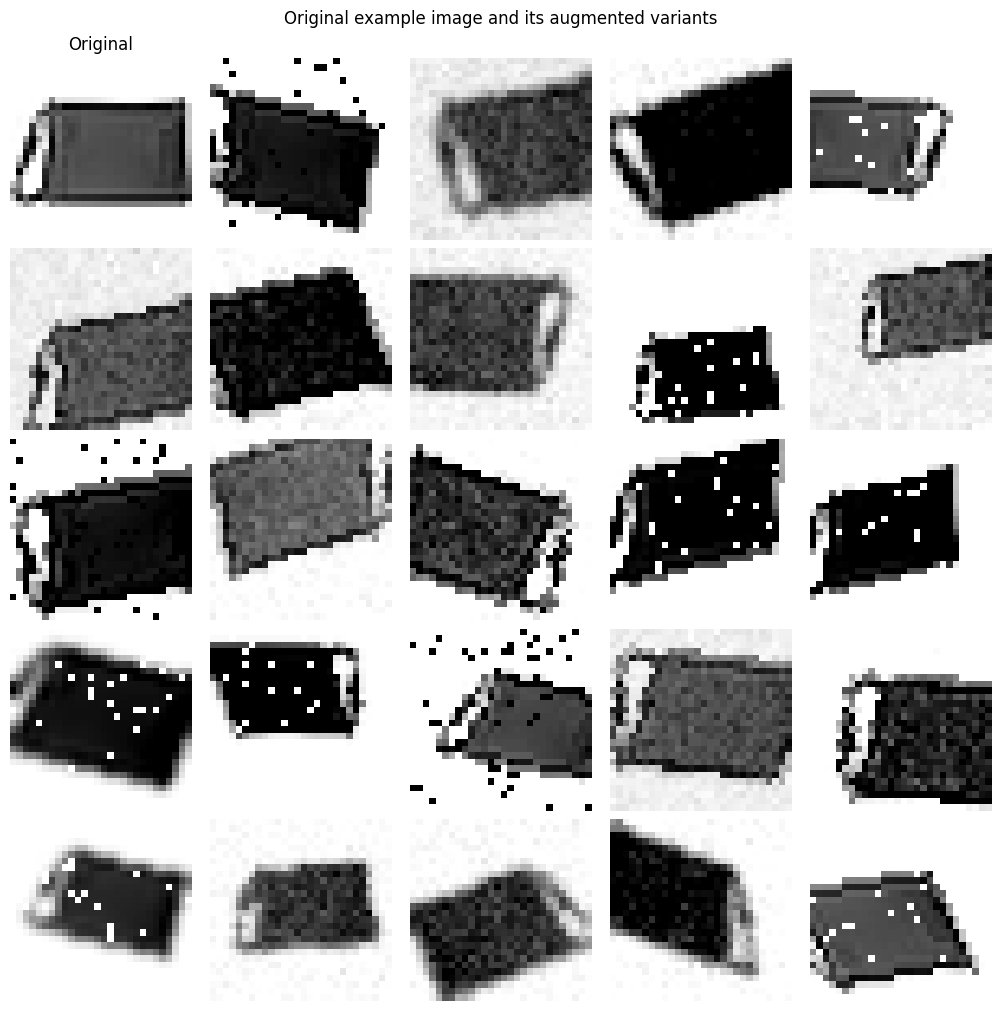

In [4]:
image = X_train[np.random.randint(len(X_train))]
augs = apply_augmentation(image, augmentation_transforms, num_samples=24)

fig, axes = plt.subplots(5, 5, figsize=(10, 10))
fig.suptitle('Original example image and its augmented variants')

for i, ax in enumerate(axes.ravel()):
    ax.axis('off')
    ax.imshow(image.reshape(int(image.shape[0]**0.5), -1) if i == 0 else augs[i-1], cmap='Greys')
    ax.set_title('Original' if i == 0 else '')

## 3.3 Fitting the Classifier

Now, let’s step into the meat of it: defining our model and getting straight to fitting it. A word of caution—this will take a while, so you might want to fetch a coffee, tidy your desk, give the cat a scratch, or find something marginally more rewarding than watching a progress bar inch along. It’s not quick, that’s for certain. Training will stop either after 100 epochs or earlier if early stopping steps in. Since we’re using validation-set augmentation—with fresh variations conjured up each time an image is pulled from the validation pool—hitting early stopping means the model is fitted well. It can’t wring any more wisdom from that ever-changing training data.

A few notes on setting up the model. Though it’s optional, it’s well worth supplying the mean and standard deviation of the training data distribution. This helps the model normalise the data properly behind the scenes, as we’ve done below. We’ll also track accuracy, so if you stick around—rather than drifting off to more compelling distractions—you’ll get periodic updates to mull over. And we’re leaning on the CUDA backend; without it, we’d be twiddling our thumbs until tomorrow, or perhaps the day after.

In [5]:
model = EfficientNetClassifier(num_classes=len(np.unique(Y_train)),
                               augmentation = augmentation_transforms,
                               metrics = ['accuracy'],
                               device='cuda',
                               mean=X_train.ravel().mean(),
                               std=X_train.ravel().std())

In [6]:
model.fit(X_train,
          Y_train,
          X_val,
          Y_val,
          augment_val = True,
          n_epochs = 100,
          patience = 10,
          batch_size = 64,
          verbose = 1)

Fitting...:  84%|▊| 84/100 [17:56<03:24, 12.81s/it, train_loss=0.9800, val_loss=1.0253, train_accuracy=0.7617, val_accu

Early stopping at epoch 85: val_loss=0.9789 (no improvement for 10 epochs)


EfficientNetClassifier(augmentation=Compose(
    RandomAffine(degrees=[-20.0, 20.0], translate=(0.2, 0.2), scale=(0.8, 1.2), shear=[-20.0, 20.0])
    RandomHorizontalFlip(p=0.25)
    RandomVerticalFlip(p=0.25)
    RandomApply(
    p=0.5
    GaussianBlur(kernel_size=(3, 3), sigma=(0.1, 1.0))
)
    RandomChoice(
    GaussianNoise(mean=0.0, std=0.05)
    <__main__.SaltAndPepperNoise object at 0x00000250816B29D0>
)(p=None)
    ColorJitter(brightness=(0.5, 1.5), contrast=(0.5, 1.5), saturation=None, hue=None)
),
                       device='cuda', mean=0.2847967, metrics=['accuracy'],
                       num_classes=10, std=0.35314462)

## 3.4 Model Evaluation

Next, let’s see how the model fared against its training and validation datasets, judging by accuracy across the epochs. We’ll plot those results and also peek at the real numbers, both with and without TTA.

From the plot below, it’s clear the model hasn’t overfitted, which is good news there, but it might still have some room to grow. It hasn’t quite settled down, suggesting early stopping, with its patience of ten epochs, may have cut things short a bit too soon. Still, let’s call it a day here and be content with what we’ve got, at least for now.

The final accuracy figures are shown below too. As you’ll notice, the model holds steady even against the test set we tucked away at the start of this venture. One more thing stands out: TTA didn’t bring any extra shine to the accuracy this time around.

Predicting: 100%|███████████████████████████████████████████| 62/62 [00:02<00:00, 22.11it/s, batch=62/62, samples=1968]


Training accuracy (TTA=0): 0.8683943089430894


Predicting: 100%|████████████████████████████████████████████| 21/21 [00:00<00:00, 22.48it/s, batch=21/21, samples=657]


Validation accuracy (TTA=0): 0.8188736681887366


Predicting: 100%|████████████████████████████████████████████| 28/28 [00:01<00:00, 22.48it/s, batch=28/28, samples=875]


Test accuracy (TTA=0): 0.8411428571428572


Predicting with TTA: 100%|██████████████████| 3100/3100 [03:25<00:00, 15.08it/s, batch=62/62, samples=98400, tta=50/50]


Training accuracy (TTA=50): 0.8399390243902439


Predicting with TTA: 100%|██████████████████| 1050/1050 [01:09<00:00, 15.07it/s, batch=21/21, samples=32850, tta=50/50]


Validation accuracy (TTA=50): 0.7960426179604262


Predicting with TTA: 100%|██████████████████| 1400/1400 [01:31<00:00, 15.29it/s, batch=28/28, samples=43750, tta=50/50]


Test accuracy (TTA=50): 0.816


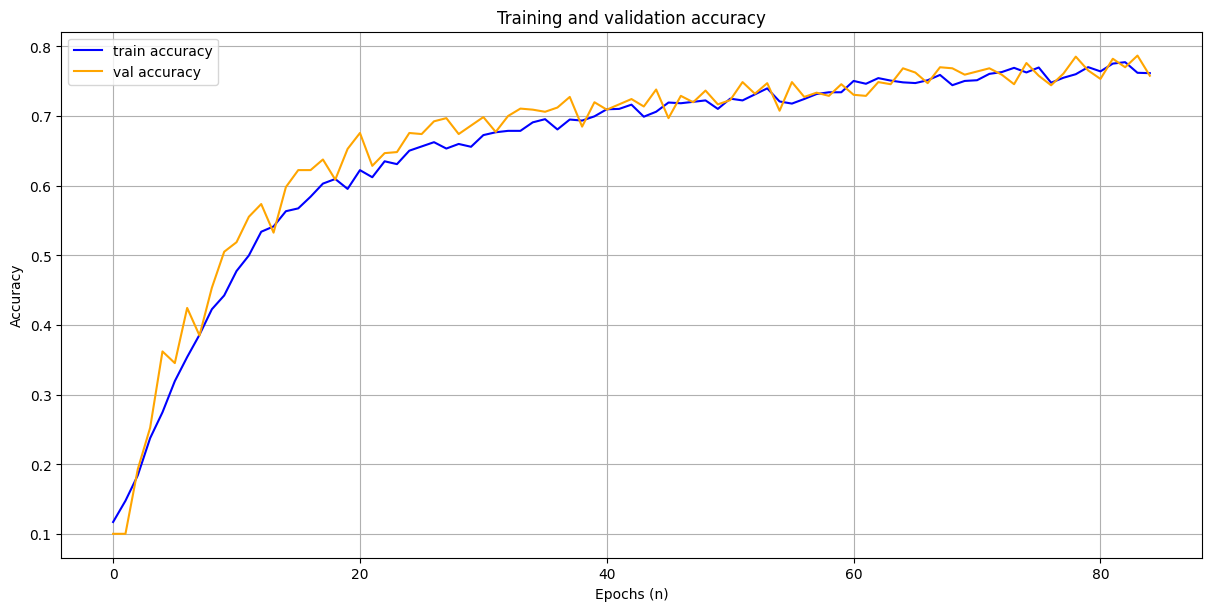

In [7]:
# Extract training and validation metrics
train_metrics, val_metrics = model.train_metrics, model.val_metrics

# Plot training and validation accuracy
fig, ax = plt.subplots()
ax.set(title='Training and validation accuracy', xlabel='Epochs (n)', ylabel='Accuracy')
ax.grid()
ax.plot(train_metrics['accuracy'], c='blue', label='train accuracy')
ax.plot(val_metrics['accuracy'], c='orange', label='val accuracy')
ax.legend()

tta = 0
print(f'Training accuracy (TTA={tta}): {accuracy_score(Y_train, model.predict(X_train, tta = tta, verbose = 1))}')
print(f'Validation accuracy (TTA={tta}): {accuracy_score(Y_val, model.predict(X_val, tta = tta, verbose = 1))}')
print(f'Test accuracy (TTA={tta}): {accuracy_score(Y_test, model.predict(X_test, tta = tta, verbose = 1))}')

tta = 50
print(f'Training accuracy (TTA={tta}): {accuracy_score(Y_train, model.predict(X_train, tta = tta, verbose = 1))}')
print(f'Validation accuracy (TTA={tta}): {accuracy_score(Y_val, model.predict(X_val, tta = tta, verbose = 1))}')
print(f'Test accuracy (TTA={tta}): {accuracy_score(Y_test, model.predict(X_test, tta = tta, verbose = 1))}')

Let’s take a quick look at the samples the model gets wrong, just to see if it holds water. As it turns out, the mispredicted examples seem reasonable enough—often enough that even I, the author, can’t always spot the correct label. No great shock there, considering I’m hardly a fashion aficionado.

Predicting: 100%|████████████████████████████████████████████| 21/21 [00:00<00:00, 22.71it/s, batch=21/21, samples=657]


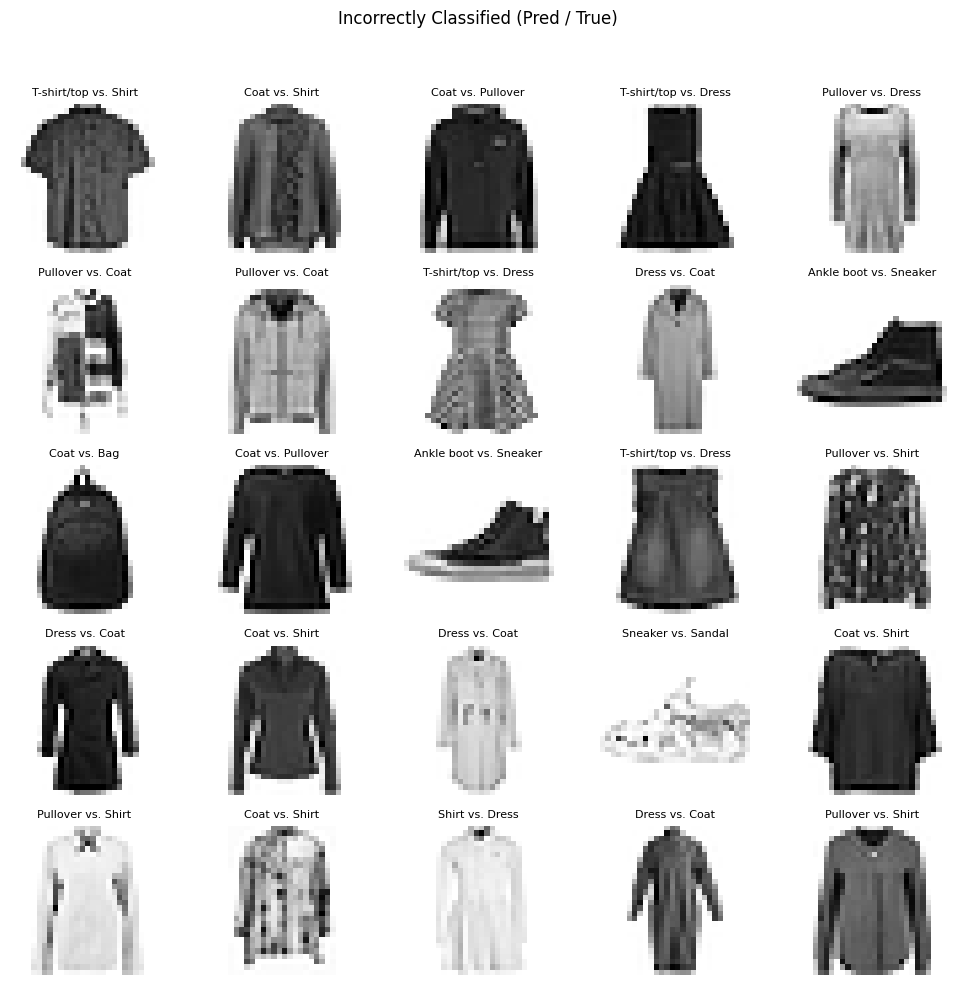

In [8]:
# Predict and find incorrect samples
Y_val_pred = model.predict(X_val, tta=0)
incorrect_idx = Y_val_pred != Y_val
X_incorrect = X_val[incorrect_idx]
Y_pred_incorrect = Y_val_pred[incorrect_idx]
Y_true_incorrect = Y_val[incorrect_idx]

# Compute square image dimension
dim = int(np.sqrt(X_val.shape[1]))

# Create 5x5 grid
fig, ax = plt.subplots(5, 5, figsize=(10, 10))
fig.suptitle('Incorrectly Classified (Pred / True)')
ax = ax.ravel()

# Plot random incorrect samples (up to 25)
n_samples = min(25, len(X_incorrect))
if n_samples:
    idxs = np.random.choice(len(X_incorrect), n_samples, replace=False)
    for i, idx in enumerate(idxs):
        ax[i].imshow(X_incorrect[idx].reshape(dim, dim), cmap='Greys')
        ax[i].set_title(f'{classes[Y_pred_incorrect[idx]]} vs. {classes[Y_true_incorrect[idx]]}', fontsize=8)
        ax[i].axis('off')
    for i in range(n_samples, 25):
        ax[i].axis('off')
    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.show()

## 3.6 Evaluating the Impact of Test-Time Augmentation

Let’s run a brief experiment to see if TTA can nudge the accuracy along, testing it with varying levels of augmentation. As the plot below shows, TTA doesn’t seem to add much here. Perhaps the model’s quite sure of itself across these altered versions, or perhaps more likely the augmentations might be a bit too difficult in the first place. To confirm that, we’d need to poke around in the predictions a bit more, but let’s leave it there for now.

Predicting...: 100%|███████████████████████████████████| 10/10 [10:13<00:00, 61.32s/it, TTA=90, accuracy=[90.    0.79]]


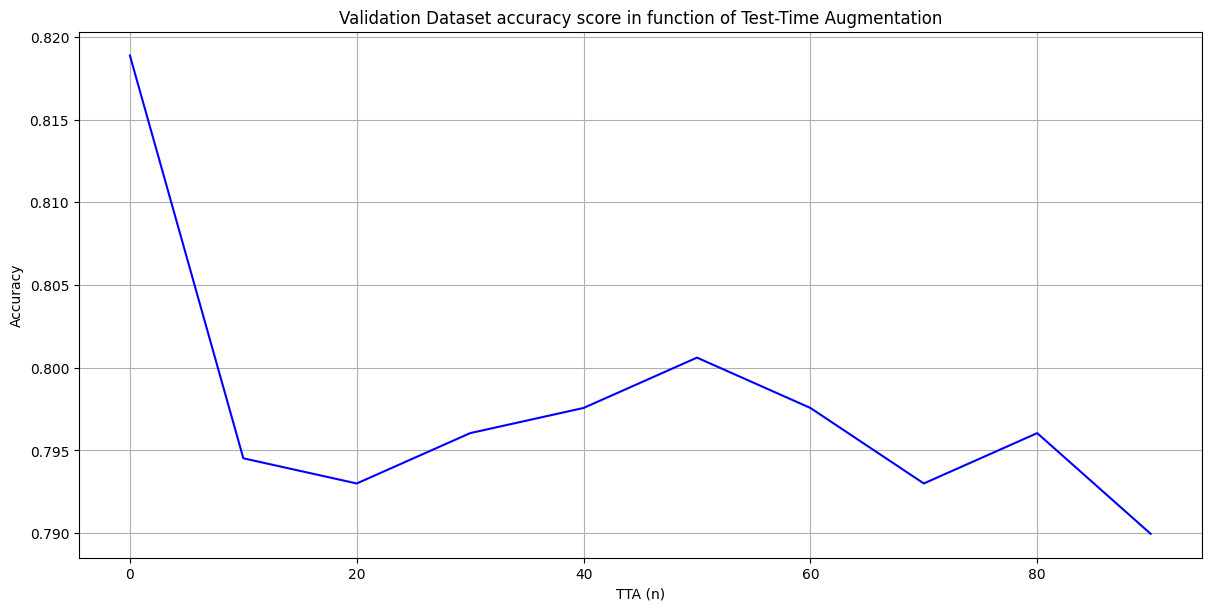

In [9]:
tta_pbar = tqdm(np.arange(0, 100, 10), desc = 'Predicting...')
tta_accuracy_scores = []
for tta in tta_pbar:
    tta_accuracy_scores.append((tta, accuracy_score(Y_val, model.predict(X_val, tta = tta, verbose = 0))))
    tta_pbar.set_postfix({'TTA': tta, 'accuracy': np.round(tta_accuracy_scores[-1], 3)})
tta_accuracy_scores = np.array(tta_accuracy_scores)

fig, ax = plt.subplots()
ax.set_title('Validation Dataset accuracy score in function of Test-Time Augmentation')
ax.set_xlabel('TTA (n)')
ax.set_ylabel('Accuracy')
ax.grid()
ax.plot(tta_accuracy_scores[:, 0], tta_accuracy_scores[:, 1], c = 'blue')

# 4. Conclusions

In this notebook, I’ve aimed to hand you a reasonably solid baseline for your greyscale image classification ventures in PyTorch—something to get you started without too much faffing about. The classes here should offer a clear stepping stone for tinkering with PyTorch’s image classification tools, sparing you the chore of sorting out the bare essentials like validation setups, early stopping, or even just getting the thing to train and predict.

As noted, the model keeps things fairly simple by design, sticking to the basics but packing a few indispensables: image augmentation (which you can tweak to your heart’s content), validation-time augmentation for a sturdier gauge during fitting, and TTA for those high-stakes moments where it might lend a hand—particularly if you’re up against tricky adversaries.